# MAP MULTI STEP EXPIREMENT

In [179]:
from __future__ import absolute_import
from __future__ import print_function

from data_utils import vectorize_data, load_paths

from data_utils import display_data, nell_eval, eval_mrr, PR_curve
from data_utils import get_model_answers, get_real_answers
from sklearn import metrics
from sklearn.model_selection import train_test_split
from itertools import chain
from six.moves import range, reduce
import pandas as pd 
import os
os.environ['KERAS_BACKEND'] = 'tensorflow'
import tensorflow as tf
import numpy as np

from sklearn.utils.fixes import signature

from keras import backend as K
from keras.models import Model
from keras.layers.embeddings import Embedding
from keras.layers import Input
from keras.layers.core import Activation, Dense, Dropout, RepeatVector
from keras.layers import Lambda, Permute, Dropout, add, multiply, dot
from keras.layers import LSTM, Conv1D, GRU, BatchNormalization
from keras.layers import TimeDistributed
from keras.models import Sequential
from keras.optimizers import Adam
from keras.layers import Reshape
from keras.layers import MaxPooling1D, Flatten
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.layers import AveragePooling1D, Bidirectional
from keras import regularizers
from keras.callbacks import LearningRateScheduler
from keras.preprocessing import sequence
from keras.layers.pooling import GlobalMaxPooling1D

from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
#from keras_pos_embd import TrigPosEmbedding
import math
import os
np.random.seed(7)

# Parameters/Users/selmee/Documents/charLevelPathEmbedding
BATCH_SIZE = 64
NUM_HOPS = 1
NUM_EPOCHS = 100
EMBEDDING_DIM = 100
LSTM_HIDDEN_UNITS = 50
MEMORY_SIZE = 500
NUM_FILTERS = 50
KERNEL_SIZE = 3
MAX_SENT_LENGTH = 10
LEARNING_RATE = 0.001
NUM_TASKS = 1
POOLING_SIZE = 2
VOCAB_SIZE = 1000
import sys
task = 'worksfor'

processed_data_dir = "/home/ailab/memory_attention_model/data/processed_data/" 
nell_dir = '/home/ailab/memory_attention_model/data/NELL-995/tasks/concept_'

precision = dict()
recall = dict()
average_precision = dict()
method_names = dict()

tasks = [
    'athleteplaysinleague',
    'worksfor',
    'organizationhiredperson',
    'athleteplayssport',
    'teamplayssport',
    'personborninlocation',
    'athletehomestadium',
    'organizationheadquarteredincity',
    'athleteplaysforteam',
    'agentbelongstoorganization',
    'teamplaysinleague',
    'personleadsorganization']

label = ['context', 'e1', 'r', 'e2', 'label']
train = pd.DataFrame(columns=label)
test = pd.DataFrame(columns=label)

for task in tasks:
    print(task)
    train0, test0 = load_paths(processed_data_dir + task)
    train = pd.concat([train, train0])
    test = pd.concat([test, test0])

#train, test = load_paths(processed_data_dir + task)

def clean_nell(line):
    return line.replace('\n', '').replace('concept:', '').replace('thing$', '').replace("concept_", '')

sort_test = []
train_pos = []
train_neg = []
test_pos = []
test_neg = []


for task in tasks:
    with open(nell_dir + task + '/train_pos', 'r') as f: # for learning a single task
        for line in f:
            e1, e2, r = clean_nell(line).split('\t')
            if (e1, r, e2) not in train_pos:
                train_pos.append((e1, r, e2))
                
    with open(nell_dir + task + '/train.pairs', 'r') as f:
        for line in f:
            pair, l = clean_nell(line).split(': ')
            e1, e2 = pair.split(',')
            if (e1, task, e2) not in train_neg and l == '-':
                train_neg.append((e1, task, e2))
                    
    with open(nell_dir + task + '/sort_test.pairs', 'r') as f: # for learning a single task
        for line in f:
            pair, l = clean_nell(line).split(': ')
            e1, e2 = pair.split(',')
            sort_test.append([e1 + '' + task, e2, 1 if l == '+' else 0])
            if l == '+':
                test_pos.append((e1, task, e2))
            else:
                test_neg.append((e1, task, e2))



num_tasks = len(tasks)    
print('number of tasks:', num_tasks)

def filter_overlap_train(x):
    sample = (x['e1'], x['r'], x['e2'])
    if x['label'] == '-':        
        return sample not in train_pos
    else:        
        return sample not in train_neg
    
print('train shape before:', train.shape)
train = train[train.apply(filter_overlap_train, axis=1)]
print('train shape after:', train.shape)

def filter_overlap_test(x):
    sample = (x['e1'], x['r'], x['e2'])
    if x['label'] == '-':
        return sample not in test_pos
    else:        
        return True #if sample not in test_neg 
    
print('test shape before:', test.shape)
test = test[test.apply(filter_overlap_test, axis=1)]
print('test shape after:', test.shape)        

data = pd.concat([train, test])
vocab = sorted(reduce(lambda x, y: x | y, (set(list(chain.from_iterable(s)) + [r]) for s, r in data[['context', 'r']].values.tolist())))
word2idx = dict((e, i + 1) for i, e in enumerate(vocab))
idx2word = dict((i + 1, e) for i, e in enumerate(vocab))
task2idx = dict((e, i) for i, e in enumerate(tasks))

MAX_SENTS = max(map(len, data['context'].values.tolist()))
MAX_SENT_LENGTH = max(map(len, chain.from_iterable(data['context'].values)))
MEMORY_SIZE = min(MEMORY_SIZE, MAX_SENTS)
VOCAB_SIZE = len(word2idx) + 1 # +1 for nil word

print("Longest sentence length", MAX_SENT_LENGTH)
print("Longest story length", MAX_SENTS)

# split train/validation/test sets
# story, relation, label, char_seq

e1_set = list(set([ e[0] for e in train[['e1']].values.tolist()]))
                         
train_e, val_e = train_test_split(e1_set, test_size=.1, random_state=None)
val = train[train['e1'].isin(val_e)]
train = train[train['e1'].isin(train_e)]
                             
trainS, trainR, trainL = vectorize_data(train, word2idx, MAX_SENT_LENGTH, MEMORY_SIZE)
valS, valR, valL = vectorize_data(val, word2idx, MAX_SENT_LENGTH, MEMORY_SIZE)
testS, testR, testL = vectorize_data(test, word2idx, MAX_SENT_LENGTH, MEMORY_SIZE)

# params
n_train = trainS.shape[0]
n_test = testS.shape[0]
n_val = valS.shape[0]

print("Training Size", n_train)
print("Validation Size", n_val)
print("Testing Size", n_test)
print("Entity&Relation Vocab Size", VOCAB_SIZE)

athleteplaysinleague
worksfor
organizationhiredperson
athleteplayssport
teamplayssport
personborninlocation
athletehomestadium
organizationheadquarteredincity
athleteplaysforteam
agentbelongstoorganization
teamplaysinleague
personleadsorganization
number of tasks: 12
train shape before: (59591, 5)
train shape after: (57935, 5)
test shape before: (22418, 5)
test shape after: (22136, 5)
Longest sentence length 7
Longest story length 385
Training Size 52213
Validation Size 5722
Testing Size 22136
Entity&Relation Vocab Size 445


In [175]:
data[data['label']=='+'].values.shape

(9387, 5)

In [176]:
data.

,context,e1,r,e2,label
0,"[[athlete, athleteplayssportsteamposition, spo...",athlete_reggie_white,athleteplaysinleague,sportsleague_nba,-
1,"[[athlete, athleteplaysforteam, sportsteam, at...",athlete_tom_glavine,athleteplaysinleague,sportsleague_major_league_baseball,-
2,"[[athlete, athleteplaysforteam, sportsteam, te...",athlete_rafael_furcal,athleteplaysinleague,person_carl_crawford,-
3,"[[athlete, athleteplayssport, sport, teamplays...",athlete_delwyn_young,athleteplaysinleague,personmexico_ncaa,-
4,"[[coach, athleteplaysforteam, sportsteam, team...",coach_gio_gonzalez,athleteplaysinleague,sportsteam_ncaa_youth_kids,-
5,"[[male, athleteledsportsteam, sportsteam, orga...",male_gerald_green,athleteplaysinleague,sportsleague_nba,+
6,"[[personmexico, athleteplayssport, sport, team...",personmexico_jose_molina,athleteplaysinleague,personmexico_ncaa,-
7,"[[coach, athleteplaysforteam, sportsteam, team...",coach_frank_robinson,athleteplaysinleague,sportsleague_western_conference,-
8,"[[athlete, athleteledsportsteam, sportsteam, t...",athlete_wallace,athleteplaysinleague,sportsleague_afc,-
9,"[[coach, athleteplayssport, sport, teamplayssp...",coach_jason_garrett,athleteplaysinleague,sportsteam_ncaa_mens_midwest_regionals,-


In [33]:

"""def sentEncoder(embedding):
    sent_model = Sequential()
    sent_model.add(embedding)
    sent_model.add(Conv1D(NUM_FILTERS, KERNEL_SIZE, padding='same', activation='relu'))
    sent_model.add(Bidirectional(LSTM(LSTM_HIDDEN_UNITS)))
    #sent_model.add(Dropout(0.1))
    return sent_model"""

from keras import backend as K
from keras.engine.topology import Layer
from keras import initializers, regularizers, constraints
from keras.layers import concatenate

import numpy as np
from keras.callbacks import Callback
from sklearn.metrics import confusion_matrix, f1_score, precision_score, recall_score

trainR1 = sequence.pad_sequences(trainR.reshape([trainR.shape[0], 1]), MAX_SENT_LENGTH)
valR1 = sequence.pad_sequences(valR.reshape([valR.shape[0], 1]), MAX_SENT_LENGTH)
testR1 = sequence.pad_sequences(testR.reshape([testR.shape[0], 1]), MAX_SENT_LENGTH)

val_unsorted = []
for e1, r, e2, l in val[['e1', 'r', 'e2', 'label']].values:
    y1 = 1 if l == '+' else 0
    val_unsorted.append(e1 + r + ' ' + e2 + ' ' + str(y1))
val_sort = []
for line in sorted(val_unsorted):
    e1_r, e2, l = line.split()
    val_sort.append([e1_r, e2, int(l)])
    
    
average_precision = []
precision = []
recall = []
def sentEncoder(embedding):
    sent_model = Sequential()
    sent_model.add(embedding)
    sent_model.add(Conv1D(NUM_FILTERS, KERNEL_SIZE, padding='same', activation='relu'))
    sent_model.add(MaxPooling1D(pool_size=POOLING_SIZE))
    sent_model.add(Bidirectional(LSTM(int(EMBEDDING_DIM/2))))
    return sent_model

def ConvBiLSTM(step):
    query = Input(shape=(MAX_SENT_LENGTH,))
    context = Input(shape=(MEMORY_SIZE, MAX_SENT_LENGTH, ))
    embedding_A = Embedding(VOCAB_SIZE, EMBEDDING_DIM, input_length=MAX_SENT_LENGTH, mask_zero=False)

    query_encoded = sentEncoder(embedding_A)(query)
    context_encoded = TimeDistributed(sentEncoder(embedding_A))(context) 
    
    u = query_encoded
    for k in range(step):
        u_rep = RepeatVector(MEMORY_SIZE)(u)
        output = concatenate([m, u_rep])
        tanh = Dense(EMBEDDING_DIM, activation='tanh')(output)
        score = Dense(1)(tanh)
        score = Flatten()(score)
        alpha = Activation('softmax', name='layer_softmax')(score)
        o = dot([alpha, context_encoded], axes=(1,1))
        u = add([o, u])
        u = Dense(EMBEDDING_DIM, input_shape=(EMBEDDING_DIM,))(u)

    prediction = Dense(1, activation='sigmoid')(u)

    model = Model([query, context], prediction)
    model.summary()

    return model

for step in list(range(7)):

    
    model = ConvBiLSTM(step)

    adam = Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-8)
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    #print(model.summary())

    #callbacks = [ModelCheckpoint(filepath='output/' + task + '_model.h5', monitor='val_loss', save_best_only=True)]
    #callbacks = [ModelCheckpoint(filepath='output/joint_model_step' + str(step) + '.h5', monitor='val_loss', save_best_only=True)]
    callbacks = [ModelCheckpoint(filepath='output/' + str(task) + '(' + str(step) + ')_single_model.h5', monitor='val_loss', save_best_only=True)]
    #callbacks = [ModelCheckpoint(filepath='output/test_model.h5', monitor='val_loss', save_best_only=True)]
    

    history = model.fit([trainS, trainR1], trainL, 
                        validation_data=([valS, valR1], valL),
                        callbacks=callbacks,
                        epochs=20,
                        batch_size=BATCH_SIZE, verbose=0) 

    from sklearn import metrics

    model.load_weights('output/' + str(task) + '(' + str(step) + ')_single_model.h5')

    #evaluation = model.evaluate([testS, testR1], testL, verbose=0)
    #print('Summary: Loss over the test dataset: %.4f, Accuracy: %.4f' % (evaluation[0], evaluation[1]))

    test_preds = model.predict([testS, testR1])
    model_answers, _ = get_model_answers(test_preds, test.values.tolist())

    score_dict = dict()
    i = 0
    for _, e1, r, e2, _ in test.values.tolist():
        score = float(test_preds[i][0])

        if (e1, e2) not in score_dict:
            score_dict[(e1+r, e2)] = score
        else:
            if score_dict[(e1+r, e2)] < score:
                score_dict[(e1+r, e2)] = score
        i+=1

    y_test = []
    scores = []
    for e1, e2, l in sort_test:
        if (e1,e2) in score_dict:
            score = score_dict[(e1, e2)]
        else:
            score = -10.
        y_test.append(l)
        scores.append(score) 


    prec, rec, avg_precision = PR_curve(model_answers, sort_test)
    precision.append(prec)
    recall.append(rec)
    average_precision.append(avg_precision)


import matplotlib.pyplot as plt

def error_map(data):
    from scipy.stats import sem, t
    from scipy import mean
    confidence = 0.95

    n = len(data)
    m = mean(data)
    std_err = sem(data)
    h = std_err * t.ppf((1 + confidence) / 2, n - 1)
    return h

In [220]:
def sentEncoder(embedding):
    sent_model = Sequential()
    sent_model.add(embedding)
    sent_model.add(Conv1D(NUM_FILTERS, KERNEL_SIZE, padding='same', activation='relu'))
    #sent_model.add(MaxPooling1D(pool_size=POOLING_SIZE))
    sent_model.add(Bidirectional(LSTM(int(EMBEDDING_DIM/2))))
    return sent_model

def ConvBiLSTM(step):
    query = Input(shape=(MAX_SENT_LENGTH,))
    context = Input(shape=(MEMORY_SIZE, MAX_SENT_LENGTH,))
    embedding_A = Embedding(VOCAB_SIZE, EMBEDDING_DIM, input_length=MAX_SENT_LENGTH, mask_zero=False)

    query_encoded = sentEncoder(embedding_A)(query)
    context_encoded = TimeDistributed(sentEncoder(embedding_A))(context) 
    
    u = query_encoded
    for k in range(step):
        u_rep = RepeatVector(MEMORY_SIZE)(u)
        output = concatenate([context_encoded, u_rep])
        tanh = Dense(EMBEDDING_DIM, activation='tanh')(output)
        score = Dense(1)(tanh)
        score = Flatten()(score)
        alpha = Activation('softmax')(score)
        o = dot([alpha, context_encoded], axes=(1,1))
        u = add([o, u])
        u = Dense(EMBEDDING_DIM, input_shape=(EMBEDDING_DIM,))(u)

    prediction = Dense(1, activation='sigmoid')(u)

    model = Model([query, context], prediction)

    return model

model = ConvBiLSTM(2)
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_59 (InputLayer)           (None, 7)            0                                            
__________________________________________________________________________________________________
input_60 (InputLayer)           (None, 385, 7)       0                                            
__________________________________________________________________________________________________
sequential_59 (Sequential)      (None, 100)          99950       input_59[0][0]                   
__________________________________________________________________________________________________
time_distributed_165 (TimeDistr (None, 385, 100)     99950       input_60[0][0]                   
__________________________________________________________________________________________________
repeat_vec

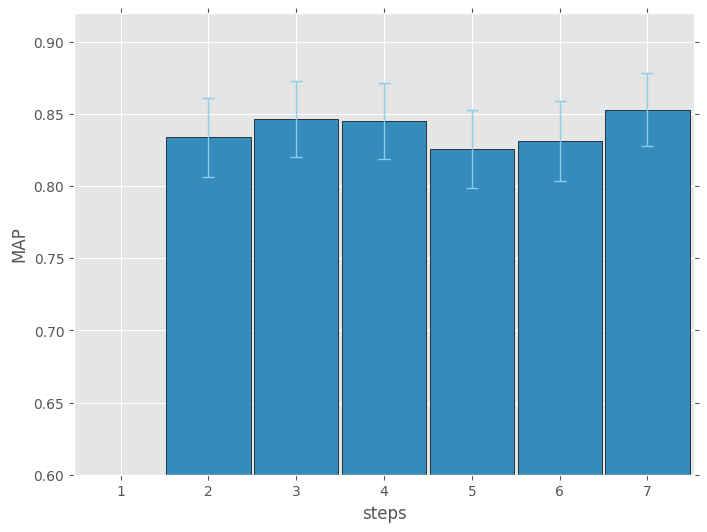

In [34]:
import matplotlib.pyplot as plt

def error_map(data):
    from scipy.stats import sem, t
    from scipy import mean
    confidence = 0.95

    n = len(data)
    m = mean(data)
    std_err = sem(data)
    h = std_err * t.ppf((1 + confidence) / 2, n - 1)
    return h
plt.style.use(['ggplot'])
#plt.style.use(['default'])
#plt.style.use('seaborn-whitegrid')

#fig, ax = plt.subplots(dpi=100, frameon=True)    
fig, ax = plt.subplots(dpi=100, frameon=True, figsize=(8, 6), facecolor='w', edgecolor='k')    

import brewer2mpl
bmap = brewer2mpl.get_map('Set2','qualitative',6,reverse=True)
colors = bmap.mpl_colors
errors = []
for p in precision:
    errors.append(error_map(p))
#average_precision[0] = 0.75
#average_precision[5] = 0.85
ax.bar(np.arange(len(average_precision)), average_precision, 0.96, color='#358CBC', yerr=errors, alpha=1, edgecolor='black', error_kw=dict(lw=1, capsize=4, capthick=1, ecolor='skyblue'))
#
plt.xticks(np.arange(len(average_precision)), list(range(1, len(average_precision)+1)))
ax.get_xaxis().set_ticks_position('both')  # Adding ticks to both top and bottom
ax.get_yaxis().set_ticks_position('both')  # Adding ticks to both top and bottom

plt.ylim([0.6, 0.92])
plt.xlim([-0.53, 6.53])
plt.xlabel("steps")
plt.ylabel("MAP")
plt.savefig('step_maps_high.png', dpi=1000, bbox_inches = 'tight', pad_inches = 0)

In [35]:
average_precision

[0.5466517559154138,
 0.8336233310105043,
 0.8462727296456514,
 0.844850379232802,
 0.8257802239987514,
 0.8310444372202092,
 0.8529537235000418]

<Figure size 640x480 with 0 Axes>

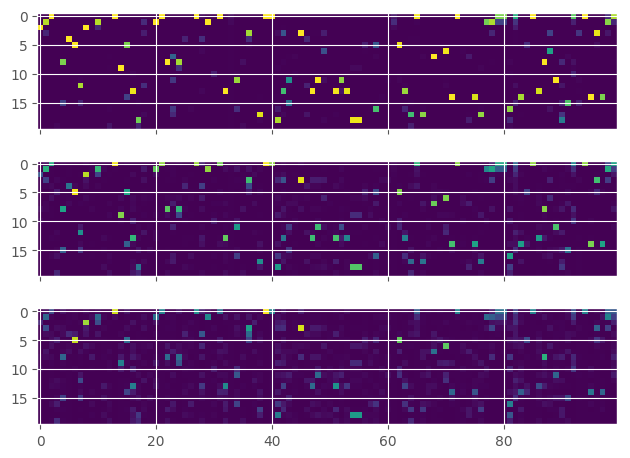

In [36]:
step = 3
model = AttNet(step)

adam = Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-8)
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
callbacks = [ModelCheckpoint(filepath='output/' + str(task) + '(' + str(step) + ')_single_model.h5', monitor='val_loss', save_best_only=True)]

model.load_weights('output/' + str(task) + '(' + str(step) + ')_single_model.h5')

evaluation = model.evaluate([testS, testR1], testL, verbose=0)

intermediate_layer_model_0 = Model(inputs=model.input, outputs=model.get_layer("layer_softmax_0").output)
intermediate_layer_model_1 = Model(inputs=model.input, outputs=model.get_layer("layer_softmax_1").output)
intermediate_layer_model_2 = Model(inputs=model.input, outputs=model.get_layer("layer_softmax_2").output)

intermediate_output_0 = intermediate_layer_model_0.predict([testS, testR1])
intermediate_output_1 = intermediate_layer_model_1.predict([testS, testR1])
intermediate_output_2 = intermediate_layer_model_2.predict([testS, testR1])

#-----------------------------------------------

import numpy as np
import matplotlib
import matplotlib.pyplot as plt

idx = testL == 1
layer0 = intermediate_output_0[idx,:20]
layer1 = intermediate_output_1[idx,:20]
layer2 = intermediate_output_2[idx,:20]

layer0 = np.transpose(layer0[:100])
layer1 = np.transpose(layer1[:100])
layer2 = np.transpose(layer2[:100])

import seaborn as sns; 

fig = plt.figure()
fig.subplots_adjust(hspace=0.4, wspace=0.4)
att_data = [layer0, layer1, layer2]

f, axarr = plt.subplots(3, sharex=True)
axarr[0].imshow(layer0)
axarr[1].imshow(layer1)
axarr[2].imshow(layer2)
    
plt.tight_layout()

plt.show()


/home/ailab/anaconda3/envs/venv/lib/python3.5/site-packages/matplotlib/figure.py:2369: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


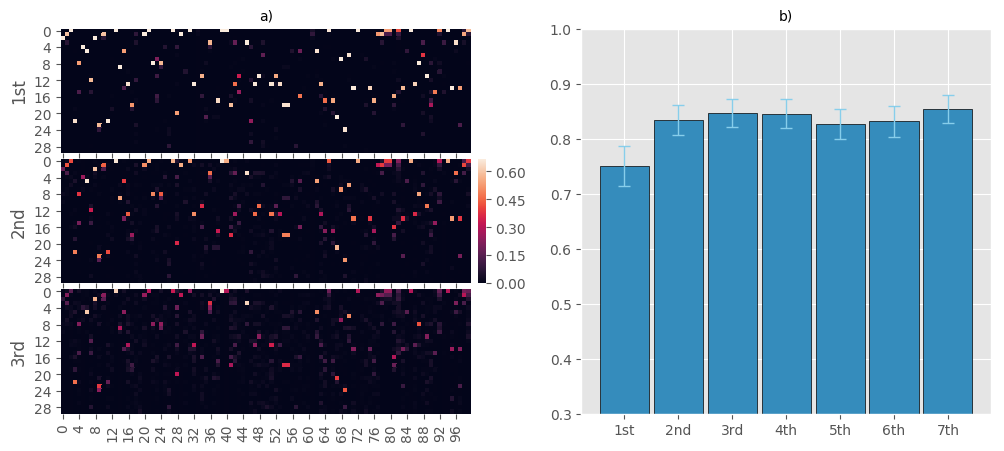

In [37]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt

idx = testL == 1
layer0 = intermediate_output_0[idx,:30]
layer1 = intermediate_output_1[idx,:30]
layer2 = intermediate_output_2[idx,:30]

layer0 = np.transpose(layer0[:100])
layer1 = np.transpose(layer1[:100])
layer2 = np.transpose(layer2[:100])

import seaborn as sns; 
import matplotlib.gridspec as gridspec
plt.style.use(['ggplot'])

att_data = [layer0, layer1, layer2]

fig = plt.figure(tight_layout=True, figsize=(12,5))
gs = gridspec.GridSpec(3, 4, width_ratios=[1,0.02,0.2,1])
gs.update(wspace=0.03, hspace=0.05)
ax1 = fig.add_subplot(gs[:, 3])
average_precision[0] = 0.75
ax1.bar(['1st', '2nd', '3rd', '4th', '5th', '6th', '7th'], average_precision, 0.91, color='#358CBC', yerr=errors, alpha=1, edgecolor='black', error_kw=dict(lw=1, capsize=4, capthick=1, ecolor='skyblue'))
ax1.set_ylim([0.3, 1])
ax1.set_title('b)', size=10)

axes = []
for i in range(3):
    ax2 = fig.add_subplot(gs[i, 0])
    axes.append(ax2)
    if i == 0:
        ax2.set_title('a)', size=10)
    ax2.set_ylabel('d')
    if i != 2:
        ax2.set_xticklabels('')
        sns.heatmap(att_data[i], ax=ax2, cbar=False)

    else:

        sns.heatmap(att_data[i], ax=ax2, cbar_ax=fig.add_subplot(gs[1,1]))

        
axes[0].set_xticklabels([])
axes[1].set_xticklabels([])
axes[0].set_ylabel('1st')
axes[1].set_ylabel('2nd')
axes[2].set_ylabel('3rd')
fig.align_labels()


plt.savefig('attention_high_multistep.png', dpi=500, bbox_inches = 'tight', pad_inches = 0)

# Visualize paths 

In [7]:
from __future__ import absolute_import
from __future__ import print_function

from data_utils import vectorize_data, load_paths

from data_utils import display_data, nell_eval, eval_mrr, PR_curve
from data_utils import get_model_answers, get_real_answers
from sklearn import metrics
from sklearn.model_selection import train_test_split
from itertools import chain
from six.moves import range, reduce
import pandas as pd 
import os
os.environ['KERAS_BACKEND'] = 'tensorflow'
import tensorflow as tf
import numpy as np

from sklearn.utils.fixes import signature

from keras import backend as K
from keras.models import Model
from keras.layers.embeddings import Embedding
from keras.layers import Input
from keras.layers.core import Activation, Dense, Dropout, RepeatVector
from keras.layers import Lambda, Permute, Dropout, add, multiply, dot
from keras.layers import LSTM, Conv1D, GRU, BatchNormalization
from keras.layers import TimeDistributed
from keras.models import Sequential
from keras.optimizers import Adam
from keras.layers import Reshape
from keras.layers import MaxPooling1D, Flatten
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.layers import AveragePooling1D, Bidirectional
from keras import regularizers
from keras.callbacks import LearningRateScheduler
from keras.preprocessing import sequence
from keras.layers.pooling import GlobalMaxPooling1D

from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
#from keras_pos_embd import TrigPosEmbedding
import math
import os
np.random.seed(7)

In [8]:
len(test.values[0][0])

9

In [11]:
test

,context,e1,r,e2,label
0,"[[athlete, athleteledsportsteam, sportsteam, o...",athlete_abreu,athleteplaysforteam,female_yankees,-
1,"[[athlete, athleteledsportsteam, sportsteam, t...",athlete_abreu,athleteplaysforteam,sportsteam_chicago_cubs,-
2,"[[athlete, athleteledsportsteam, sportsteam, t...",athlete_abreu,athleteplaysforteam,sportsteam_chowan_braves,-
3,"[[athlete, athleteledsportsteam, sportsteam, t...",athlete_abreu,athleteplaysforteam,sportsteam_houston_astros,-
4,"[[athlete, athleteledsportsteam, sportsteam, a...",athlete_abreu,athleteplaysforteam,sportsteam_new_york_mets,-
5,"[[athlete, athleteledsportsteam, sportsteam, t...",athlete_abreu,athleteplaysforteam,sportsteam_philadelphia_phillies,-
6,"[[athlete, athleteledsportsteam, sportsteam, t...",athlete_abreu,athleteplaysforteam,sportsteam_phillies,-
7,"[[athlete, athleteledsportsteam, sportsteam, t...",athlete_abreu,athleteplaysforteam,sportsteam_red_sox,-
8,"[[athlete, athleteledsportsteam, sportsteam, t...",athlete_abreu,athleteplaysforteam,sportsteam_red_sox_this_season,-
9,"[[athlete, athleteledsportsteam, sportsteam, t...",athlete_abreu,athleteplaysforteam,sportsteam_steelers,-


295


295
0.666909 : athlete athletehomestadium stadiumoreventvenue athletehomestadium_inv athlete athleteplaysforteam sportsteam
0.155353 : athlete athleteledsportsteam sportsteam athleteledsportsteam_inv athlete athleteplaysforteam sportsteam
0.064826 : athlete athletehomestadium stadiumoreventvenue athletehomestadium_inv athlete athleteledsportsteam sportsteam
0.059186 : athlete athletehomestadium stadiumoreventvenue athletehomestadium_inv athlete personbelongstoorganization sportsteam
0.020108 : athlete athleteledsportsteam sportsteam personbelongstoorganization_inv person athleteplaysforteam sportsteam
0.015625 : athlete athleteledsportsteam sportsteam worksfor_inv person athleteledsportsteam sportsteam


athleteplaysinleague


/home/ailab/anaconda3/envs/venv/lib/python3.5/re.py:203: FutureWarning: split() requires a non-empty pattern match.
  return _compile(pattern, flags).split(string, maxsplit)


worksfor
organizationhiredperson
athleteplayssport
teamplayssport
personborninlocation
athletehomestadium
organizationheadquarteredincity
athleteplaysforteam
agentbelongstoorganization
teamplaysinleague
personleadsorganization
athleteplaysinleague
worksfor
organizationhiredperson
athleteplayssport
teamplayssport
personborninlocation
athletehomestadium
organizationheadquarteredincity
athleteplaysforteam
agentbelongstoorganization
teamplaysinleague
personleadsorganization


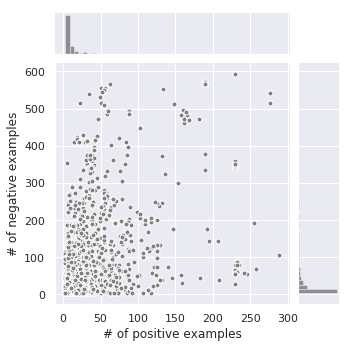

In [8]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
processed_data_dir = "/home/ailab/memory_attention_model/data/processed_data/" 
tasks = [
    'athleteplaysinleague',
    'worksfor',
    'organizationhiredperson',
    'athleteplayssport',
    'teamplayssport',
    'personborninlocation',
    'athletehomestadium',
    'organizationheadquarteredincity',
    'athleteplaysforteam',
    'agentbelongstoorganization',
    'teamplaysinleague',
    'personleadsorganization']
label = ['context', 'e1', 'r', 'e2', 'label']
train = pd.DataFrame(columns=label)
test = pd.DataFrame(columns=label)

for task in tasks:
    print(task)
    train0, test0 = load_paths(processed_data_dir + task)
    train = pd.concat([train, train0])
    test = pd.concat([test, test0])
    
x = []
y = []
z = []
for task in tasks:
    print(task)
    all_paths = set()
    task_df = train[train['r'] == task]
    
    for d in task_df.values:

        pp = list(map(lambda p0: ' '.join(p0), d[0]))

        for p in set(pp):
            all_paths.add(p)
            
    for p in all_paths:        
        pos = 0
        neg = 0
        
        for d in task_df.values:
            if p in set(map(lambda p0: ' '.join(p0), d[0])):
                if d[-1] == '+':
                    pos += 1
                else:
                    neg += 1
        x.append(pos)
        y.append(neg)
        z.append(task)
        
data1 = np.column_stack((x,y))            


import pandas as pd
import seaborn as sns
sns.set(style="darkgrid", color_codes=True)


#data = np.unique(data,axis=0)
df = pd.DataFrame(data1, columns=["# of positive examples", "# of negative examples"])
df1 = df[(df['# of negative examples'] > 2) & (df['# of negative examples'] < 600)]
df_nell = df1[(df1['# of positive examples'] < 300) & (df1['# of positive examples'] > 2)] 

g = sns.JointGrid(x="# of positive examples", y="# of negative examples", data=df_nell, height=5, ratio=5);
g = g.plot_joint(plt.scatter, color='.5', edgecolor="white", s=25)
g = g.plot_marginals(sns.distplot, kde=False, color='.01')

plt.savefig('scatter_path_dist_nell.png', dpi=500, bbox_inches = 'tight', pad_inches = 0)

# path embedding visualization

In [40]:
from __future__ import absolute_import
from __future__ import print_function

from data_utils import vectorize_data, load_paths

from data_utils import display_data, nell_eval, eval_mrr
from data_utils import get_model_answers, get_real_answers
from sklearn import metrics
from sklearn.model_selection import train_test_split
from itertools import chain
from six.moves import range, reduce
import pandas as pd 
import os
os.environ['KERAS_BACKEND'] = 'tensorflow'
import tensorflow as tf
import numpy as np

from sklearn.utils.fixes import signature

from keras import backend as K
from keras.models import Model
from keras.layers.embeddings import Embedding
from keras.layers import Input
from keras.layers.core import Activation, Dense, Dropout, RepeatVector
from keras.layers import Lambda, Permute, Dropout, add, multiply, dot
from keras.layers import LSTM, Conv1D, GRU, BatchNormalization
from keras.layers import TimeDistributed
from keras.models import Sequential
from keras.optimizers import Adam
from keras.layers import Reshape
from keras.layers import MaxPooling1D, Flatten
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.layers import AveragePooling1D, Bidirectional
from keras import regularizers
from keras.callbacks import LearningRateScheduler
from keras.preprocessing import sequence
from keras.layers.pooling import GlobalMaxPooling1D

from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
#from keras_pos_embd import TrigPosEmbedding
import math
import sys
import os
np.random.seed(7)

#config = tf.ConfigProto(device_count={"CPU": 20})
#K.tensorflow_backend.set_session(tf.Session(config=config))

config = tf.ConfigProto(intra_op_parallelism_threads=20, inter_op_parallelism_threads=20, \
    allow_soft_placement=True, device_count={'CPU': 20})
session = tf.Session(config=config)
K.set_session(session)

# Parameters/Users/selmee/Documents/charLevelPathEmbedding
#BATCH_SIZE = 64
BATCH_SIZE = 128
NUM_HOPS = 2
#NUM_EPOCHS = 50
NUM_EPOCHS = 50
EMBEDDING_DIM = 100
LSTM_HIDDEN_UNITS = 100
MEMORY_SIZE = 5000
NUM_FILTERS = 50
KERNEL_SIZE = 3
MAX_SENT_LENGTH = 10
LEARNING_RATE = 0.0001
NUM_TASKS = 1
POOLING_SIZE = 2
VOCAB_SIZE = 1000
PATIENCE = 30


processed_data_dir = "/home/ailab/memory_attention_model/data/processed_data/" 
nell_dir = '/home/ailab/memory_attention_model/data/NELL-995/tasks/concept_'


task_dir = nell_dir


print('task dir:', task_dir)
precision = dict()
recall = dict()

method_names = dict()

tasks = [
    'athleteplaysinleague',
    'worksfor',
    'organizationhiredperson',
    'athleteplayssport',
    'teamplayssport',
    'personborninlocation',
    'athletehomestadium',
    'organizationheadquarteredincity',
    'athleteplaysforteam',
    'teamplaysinleague']
#tasks = [task]

label = ['context', 'e1', 'r', 'e2', 'label']
train = pd.DataFrame(columns=label)
test = pd.DataFrame(columns=label)

for task in tasks:
    print('task name:', task)
    train0, test0 = load_paths(processed_data_dir + task)
    train = pd.concat([train, train0])
    test = pd.concat([test, test0])

#train, test = load_paths(processed_data_dir + task)

def clean_nell(line):
    return line.replace('\n', '').replace('concept:', '').replace('thing$', '').replace("concept_", '')

sort_test = []
train_pos = []
train_neg = []
test_pos = []
test_neg = []

for task in tasks:
    task_uri = task
    with open(task_dir + task + '/train_pos', 'r') as f: # for learning a single task
        for line in f:
            e1, e2, r = clean_nell(line).lower().split('\t')
            if (e1, r, e2) not in train_pos:
                train_pos.append((e1, r, e2))
                
    with open(task_dir + task + '/train.pairs', 'r') as f:
        for line in f:
            pair, l = clean_nell(line).lower().split(': ')
            e1, e2 = pair.split(',')
            if (e1, task_uri.lower(), e2) not in train_neg and l == '-':
                train_neg.append((e1, task, e2))
                    
    with open(task_dir + task + '/sort_test.pairs', 'r') as f: # for learning a single task
        for line in f:
            pair, l = clean_nell(line).lower().split(': ')
            e1, e2 = pair.split(',')
            e1_uri = e1.lower()
            e2_uri = e2.lower()

            sort_test.append([e1_uri + '' + task_uri, e2_uri, 1 if l == '+' else 0])  
            if l == '+':
                test_pos.append((e1_uri, task_uri, e2_uri))
            else:
                test_neg.append((e1_uri, task_uri, e2_uri))

num_tasks = len(tasks)    
print('number of tasks:', num_tasks)

def filter_overlap_train(x):
    sample = (x['e1'], x['r'], x['e2'])
    if x['label'] == '-':        
        return sample not in train_pos
    else:        
        return sample not in train_neg

print('train shape before:', train.shape)
train = train[train.apply(filter_overlap_train, axis=1)]
print('train shape after:', train.shape)

def filter_overlap_test(x):
    sample = (x['e1'], x['r'], x['e2'])
    if x['label'] == '-':
        return sample not in test_pos
    else:        
        return True #if sample not in test_neg 

print('test shape before:', test.shape)
test = test[test.apply(filter_overlap_test, axis=1)]
print('test shape after:', test.shape)        

data = pd.concat([train, test])
vocab = sorted(reduce(lambda x, y: x | y, (set(list(chain.from_iterable(s)) + [r]) for s, r in data[['context', 'r']].values.tolist())))
word2idx = dict((e, i + 1) for i, e in enumerate(vocab))
idx2word = dict((i + 1, e) for i, e in enumerate(vocab))
task2idx = dict((e, i) for i, e in enumerate(tasks))

MAX_SENTS = max(map(len, data['context'].values.tolist()))
MAX_SENT_LENGTH = max(map(len, chain.from_iterable(data['context'].values)))
MEMORY_SIZE = min(MEMORY_SIZE, MAX_SENTS)
VOCAB_SIZE = len(word2idx) + 1 # +1 for nil word

print("Longest sentence length", MAX_SENT_LENGTH)
print("Longest story length", MAX_SENTS)

# split train/validation/test sets
# story, relation, label, char_seq
S, R, L = vectorize_data(train, word2idx, MAX_SENT_LENGTH, MEMORY_SIZE)
trainS, valS, trainR, valR, trainL, valL = train_test_split(S, R, L, test_size=.3, random_state=None)
testS, testR, testL = vectorize_data(test, word2idx, MAX_SENT_LENGTH, MEMORY_SIZE)

# params
n_train = trainS.shape[0]
n_test = testS.shape[0]
n_val = valS.shape[0]

print("Training Size", n_train)
print("Validation Size", n_val)
print("Testing Size", n_test)
print("Entity&Relation Vocab Size", VOCAB_SIZE)


def sentEncoder(embedding):
    sent_model = Sequential()
    sent_model.add(embedding)
    sent_model.add(Conv1D(NUM_FILTERS, KERNEL_SIZE, padding='same', activation='relu'))
    sent_model.add(MaxPooling1D(pool_size=POOLING_SIZE))
    sent_model.add(Bidirectional(LSTM(LSTM_HIDDEN_UNITS)))
    return sent_model

def AttNet():
    query = Input(shape=(MAX_SENT_LENGTH,))
    context = Input(shape=(MEMORY_SIZE, MAX_SENT_LENGTH, ))
    embedding_layer = Embedding(VOCAB_SIZE, EMBEDDING_DIM, input_length=MAX_SENT_LENGTH, mask_zero=False)

    query_encoded = sentEncoder(embedding_layer)(query)

    context_encoded = TimeDistributed(sentEncoder(embedding_layer))(context) 
    context_dense = TimeDistributed(Dense(2 * LSTM_HIDDEN_UNITS))(context_encoded)
    
    yd = context_encoded
    u = query_encoded
    for _ in range(3):
        query_encoded_rpt = RepeatVector(MEMORY_SIZE)(u)
        query_dense = TimeDistributed(Dense(2 * LSTM_HIDDEN_UNITS))(query_encoded_rpt)
        story_query_sum = add([context_dense, query_dense])
        m = Activation('tanh')(story_query_sum)
        w_m = TimeDistributed(Dense(1))(m)
        w_m_flat = Flatten()(w_m)
        s = Activation('softmax')(w_m_flat)
        r = dot([s, yd], axes=(1,1)) 
        
        g_r = Dense(LSTM_HIDDEN_UNITS)(r)
        g_u = Dense(LSTM_HIDDEN_UNITS)(u)
        g_r_plus_g_u = add([g_r, g_u])
        u = Dense(2*LSTM_HIDDEN_UNITS, activation='relu')(g_r_plus_g_u)
        
    u = Dense(LSTM_HIDDEN_UNITS, activation='relu')(u)
    u = Dense(int(LSTM_HIDDEN_UNITS/2), activation='relu')(u)

    result = Dense(1, activation='sigmoid')(u)
    model = Model([context, query], result)
    return model

model = AttNet()

adam = Adam(lr=LEARNING_RATE, beta_1=0.9, beta_2=0.999, epsilon=1e-8)
model.compile(loss='binary_crossentropy', optimizer=adam, metrics=['accuracy'])
print(model.summary())

trainR1 = sequence.pad_sequences(trainR.reshape([trainR.shape[0], 1]), MAX_SENT_LENGTH)
valR1 = sequence.pad_sequences(valR.reshape([valR.shape[0], 1]), MAX_SENT_LENGTH)
testR1 = sequence.pad_sequences(testR.reshape([testR.shape[0], 1]), MAX_SENT_LENGTH)

callbacks = [ModelCheckpoint(filepath='output/joint_model.h5', monitor='val_loss', save_best_only=True)]

model.load_weights('output/joint_model.h5')

task dir: /home/ailab/memory_attention_model/data/NELL-995/tasks/concept_
task name: athleteplaysinleague


/home/ailab/anaconda3/envs/venv/lib/python3.5/re.py:203: FutureWarning: split() requires a non-empty pattern match.
  return _compile(pattern, flags).split(string, maxsplit)


task name: worksfor
task name: organizationhiredperson
task name: athleteplayssport
task name: teamplayssport
task name: personborninlocation
task name: athletehomestadium
task name: organizationheadquarteredincity
task name: athleteplaysforteam
task name: teamplaysinleague
number of tasks: 10
train shape before: (53009, 5)
train shape after: (51655, 5)
test shape before: (20313, 5)
test shape after: (20092, 5)
Longest sentence length 7
Longest story length 385
Training Size 36158
Validation Size 15497
Testing Size 20092
Entity&Relation Vocab Size 436
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_39 (InputLayer)           (None, 7)            0                                            
__________________________________________________________________________________________________
input_40 (InputLayer)           (None, 385, 7)

In [159]:
time_distributed_layer = Model(inputs=model.input, outputs=model.get_layer("add_113").output) # add([context_dense, query_dense])
time_distributed_output = time_distributed_layer.predict([testS, testR1])

In [13]:
att1 = intermediate_output_1[idx,:]

print(len(att1))
zipped = zip(att1[0, :len(paths)], paths)
for a, p in sorted(zipped, key=lambda x: x[0], reverse=True):
    if a > 0.01:
        print('{:f}'.format(a) + " : " + p)

295
0.555289 : athlete athletehomestadium stadiumoreventvenue athletehomestadium_inv athlete athleteplaysforteam sportsteam
0.190604 : athlete athleteledsportsteam sportsteam athleteledsportsteam_inv athlete athleteplaysforteam sportsteam
0.078736 : athlete athletehomestadium stadiumoreventvenue athletehomestadium_inv athlete athleteledsportsteam sportsteam
0.073697 : athlete athletehomestadium stadiumoreventvenue athletehomestadium_inv athlete personbelongstoorganization sportsteam
0.033526 : athlete athleteledsportsteam sportsteam personbelongstoorganization_inv person athleteplaysforteam sportsteam
0.031003 : athlete athleteledsportsteam sportsteam worksfor_inv person athleteledsportsteam sportsteam
0.016675 : athlete athleteledsportsteam sportsteam worksfor_inv person athleteplaysforteam sportsteam
0.015810 : athlete athletehomestadium stadiumoreventvenue leaguestadiums_inv sportsleague teamplaysinleague_inv sportsteam


In [160]:
print(time_distributed_output.shape)
relation_set = set(map(lambda x: x[-3], test.values))
relation_dict = dict(zip(relation_set, list(range(len(relation_set)))))
vectors = []

relation_ids = []
for i in range(len(test.values)):
    relation_ids.append( relation_dict[test.values[i][-3]] )
relation_ids = np.array(relation_ids)
labels = []

for r in relation_set:
    r_id = relation_dict[r]
    task_df = test[test['r'] == r]
    print(len(task_df.values))
    task_data = time_distributed_output[relation_ids==r_id]
    for i in range(20):
        if task_df.values[i][-1] == "+":
            n = len(task_df.values[i][0])
            for j in range(n):
                vector = task_data[i,j,:]
                vectors.append(vector)
                rel_id = relation_dict[task_df.values[i][-3]]
                labels.append(rel_id)
vectors = np.array(vectors)     
print(vectors.shape)
labels = np.array(labels)

(20092, 385, 200)
3079
2873
1821
1764
1891
2418
2061
710
1557
1918
(546, 200)


In [161]:
import numpy as np
from sklearn.manifold import TSNE
tsne_result = TSNE(n_components=2, verbose=1, n_iter=300, perplexity=10, random_state=0).fit_transform(vectors)

[t-SNE] Computing 31 nearest neighbors...
[t-SNE] Indexed 546 samples in 0.004s...
[t-SNE] Computed neighbors for 546 samples in 0.047s...
[t-SNE] Computed conditional probabilities for sample 546 / 546
[t-SNE] Mean sigma: 0.196581
[t-SNE] KL divergence after 250 iterations with early exaggeration: 57.002918
[t-SNE] KL divergence after 300 iterations: 0.489085


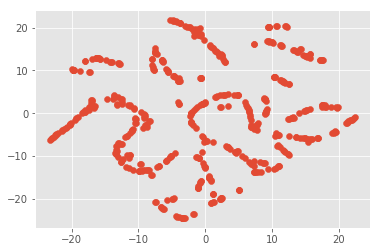

In [162]:
import matplotlib.pyplot as plt

%matplotlib inline

plt.scatter(tsne_result[:, 0], tsne_result[:, 1])

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches

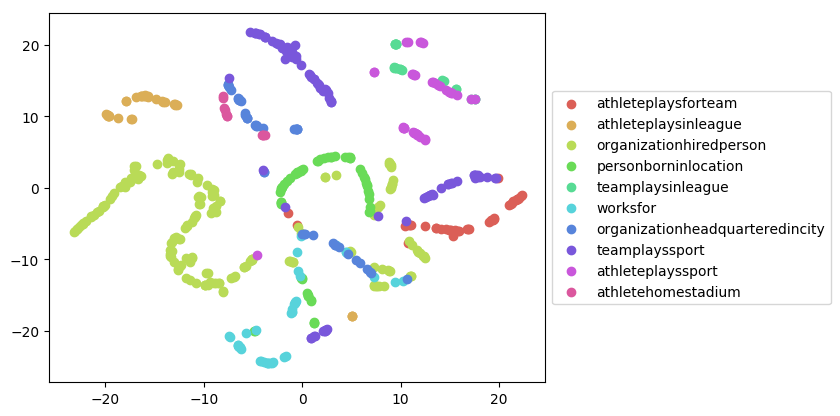

In [164]:
import seaborn as sns
import matplotlib as mpl

mpl.rcParams.update(mpl.rcParamsOrig)
mpl.rcParams.update(mpl.rcParamsDefault)

palette = np.array(sns.color_palette("hls", len(relation_set)))

colors = 'r', 'g', 'b', 'c', 'm', 'y', 'k', 'w', 'orange', 'purple'
#fig, ax = plt.subplots(dpi=100, frameon=True, figsize=(8, 6), facecolor='w', edgecolor='k')    
for r, c in zip(relation_set, colors):
    i = relation_dict[r]
    plt.scatter(tsne_result[labels == i, 0], tsne_result[labels == i, 1], c=palette[i], label=r)
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5)) 

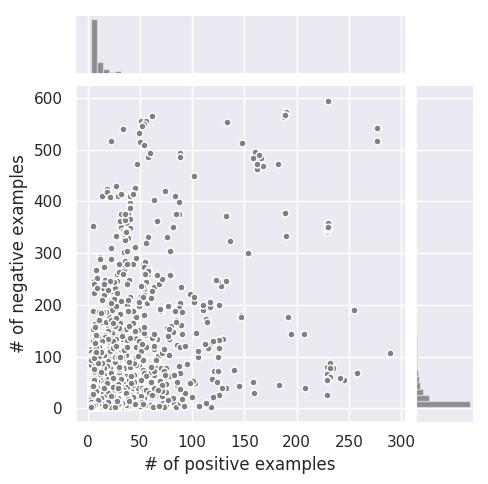

In [46]:

import pandas as pd
import seaborn as sns
sns.set(style="darkgrid", color_codes=True)


#data = np.unique(data,axis=0)
df = pd.DataFrame(data1, columns=["# of positive examples", "# of negative examples"])
df1 = df[(df['# of negative examples'] > 2) & (df['# of negative examples'] < 600)]
df_nell = df1[(df1['# of positive examples'] < 300) & (df1['# of positive examples'] > 2)] 

g = sns.JointGrid(x="# of positive examples", y="# of negative examples", data=df_nell, height=5, ratio=5);
g = g.plot_joint(plt.scatter, color='.5', edgecolor="white", s=25)
g = g.plot_marginals(sns.distplot, kde=False, color='.01')

plt.savefig('scatter_path_dist_nell.png', dpi=500, bbox_inches = 'tight', pad_inches = 0)

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches

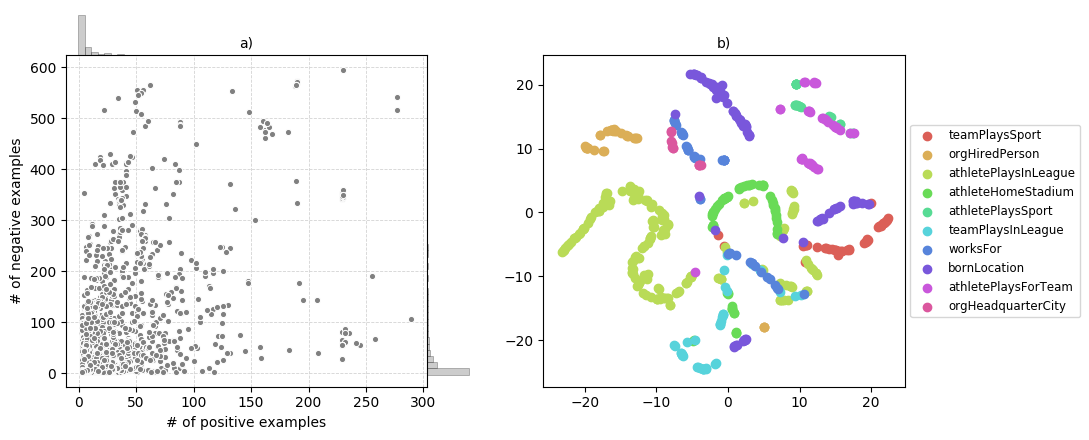

In [47]:
import matplotlib.gridspec as gridspec
import matplotlib.pyplot as plt
import matplotlib as mpl
sns.set(style="whitegrid", color_codes=True)
mpl.rcParams.update(mpl.rcParamsOrig)
mpl.rcParams.update(mpl.rcParamsDefault)

fig = plt.figure(tight_layout=True, figsize=(11,4.5))
gs = gridspec.GridSpec(2, 4, width_ratios=[1,0.12,0.2,1], height_ratios=[0.12, 0.95])
#gs.update(wspace=0.016, hspace=0.025)
gs.update(wspace=0.0, hspace=0.0)

ax2 = fig.add_subplot(gs[1:,3])

hist_ax1 = fig.add_subplot(gs[0,0])
hist_ax2 = fig.add_subplot(gs[1,1])


hist_ax1.get_xaxis().set_ticks([])
hist_ax1.get_yaxis().set_ticks([])
hist_ax2.get_xaxis().set_ticks([])
hist_ax2.get_yaxis().set_ticks([])

hist_ax1.spines['top'].set_visible(False)
hist_ax1.spines['right'].set_visible(False)
hist_ax1.spines['bottom'].set_visible(False)
hist_ax1.spines['left'].set_visible(False)
hist_ax2.spines['top'].set_visible(False)
hist_ax2.spines['right'].set_visible(False)
hist_ax2.spines['bottom'].set_visible(False)
hist_ax2.spines['left'].set_visible(False)

hist_ax1.set_xlim(-8, 310)
hist_ax2.set_ylim(-20, 610)
palette = np.array(sns.color_palette("hls", len(relation_set)))

main_ax1 = fig.add_subplot(gs[1,0])
main_ax1.set_axisbelow(True)
main_ax1.grid(color='lightgrey', linestyle='dashed', linewidth=0.6)

g3 = sns.distplot(df_nell.values[:,0], ax=hist_ax1, kde=False, color="grey", hist_kws=dict(edgecolor='k', linewidth=.5))
g4 = sns.distplot(df_nell.values[:,1], ax=hist_ax2, vertical=True, kde=False, color="grey", hist_kws=dict(edgecolor='k', linewidth=.5))
g5 = sns.scatterplot(x="# of positive examples", y="# of negative examples", data=df_nell, ax=main_ax1, s=20, color="grey");

relation_set1 = [None] * len(relation_set)
relation_set1[0] = 'teamPlaysSport'
relation_set1[1] = 'orgHiredPerson'
relation_set1[2] = 'athletePlaysInLeague'
relation_set1[3] = 'athleteHomeStadium'
relation_set1[4] = 'athletePlaysSport'
relation_set1[5] = 'teamPlaysInLeague'
relation_set1[6] = 'worksFor'
relation_set1[7] = 'bornLocation'
relation_set1[8] = 'athletePlaysForTeam'
relation_set1[9] = 'orgHeadquarterCity'

hist_ax2.grid()
hist_ax1.grid()
for j, r, c in zip(list(range(len(relation_set))), relation_set, colors):
    i = relation_dict[r]
    ax2.scatter(tsne_result[labels == i, 0], tsne_result[labels == i, 1], c=palette[i], label=relation_set1[j])
ax2.legend(loc='center left', bbox_to_anchor=(1, 0.5), fontsize=8.5) 

#ax2.set_axisbelow(True)
#ax2.grid(color='lightgrey', linestyle='dashed', linewidth=0.6)
main_ax1.set_title("a)", size=10)
ax2.set_title("b)", size=10)
plt.savefig('path_visualization.png', dpi=500, bbox_inches = 'tight', pad_inches = 0)

# Display path weights

In [165]:
time_distributed_layer = Model(inputs=model.input, outputs=model.get_layer("activation_63").output)
time_distributed_output = time_distributed_layer.predict([testS, testR1])

In [166]:
idx = []
paths = []
relations = []
for i in range(len(test.values)):
    if test.values[i][-1] == '+':
        idx.append(1)        
        paths.append(test.values[i][0])
        relations.append(test.values[i][-3])
    else:
        idx.append(0)
print(len(paths))
print(len(relations))

2696
2696


In [167]:
idx = np.array(idx)
att0 = time_distributed_output[idx==1,:]


for t in tasks: 
    cand_idx = []
    for j in range(len(relations)):
        if relations[j] == t:
            cand_idx.append(j)
    k = np.random.choice(cand_idx)

    k_paths = list(map(lambda x: ' '.join(x), paths[k]))
    
    zipped = zip(att0[k, :len(k_paths)], k_paths)
    print(relations[k])
    for a, p in sorted(zipped, key=lambda x: x[0], reverse=True):
        if a > 0.01:
            print('{:f}'.format(a) + " : " + p)

athleteplaysinleague
0.046398 : athlete athletehomestadium stadiumoreventvenue athletehomestadium_inv athlete athleteplaysinleague sportsleague
0.044520 : athlete athleteplaysforteam sportsteam coachesteam_inv coach coachesinleague sportsleague
0.039786 : athlete athleteplaysforteam sportsteam teamplaysinleague sportsleague agentcompeteswithagent sportsleague
0.037361 : athlete athletehomestadium stadiumoreventvenue leaguestadiums_inv sportsleague agentcompeteswithagent sportsleague
0.036553 : athlete athleteplaysforteam sportsteam worksfor_inv person coachesinleague sportsleague
0.036013 : athlete athleteplaysforteam sportsteam organizationhiredperson person coachesinleague sportsleague
0.035101 : athlete athleteplaysforteam sportsteam teamplaysinleague sportsleague agentcompeteswithagent_inv sportsleague
0.034798 : athlete athletehomestadium stadiumoreventvenue teamhomestadium_inv sportsteam teamplaysinleague sportsleague
0.034043 : athlete athleteplaysforteam sportsteam athleteplays

# Visualize

In [ ]:
intermediate_layer_model_0 = Model(inputs=model.input, outputs=model.get_layer("activation_59").output)
intermediate_layer_model_1 = Model(inputs=model.input, outputs=model.get_layer("activation_61").output)
intermediate_layer_model_2 = Model(inputs=model.input, outputs=model.get_layer("activation_63").output)

intermediate_output_0 = intermediate_layer_model_0.predict([testS, testR1])
intermediate_output_1 = intermediate_layer_model_1.predict([testS, testR1])
intermediate_output_2 = intermediate_layer_model_2.predict([testS, testR1])


<Figure size 640x480 with 0 Axes>

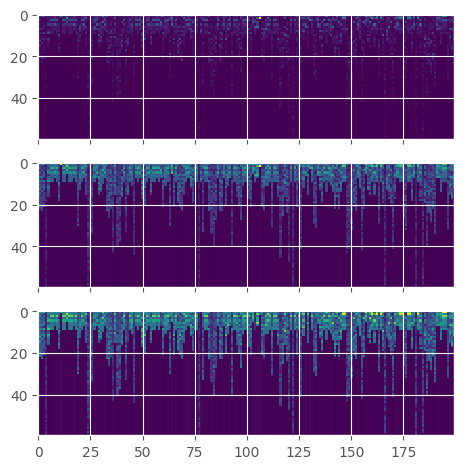

In [149]:

#-----------------------------------------------

import numpy as np
import matplotlib
import matplotlib.pyplot as plt

idx = testL == 1

layer0 = intermediate_output_0[idx,:60]
layer1 = intermediate_output_1[idx,:60]
layer2 = intermediate_output_2[idx,:60]

rand_idx = np.array(range(100, 300)) #np.random.randint(layer0.shape[0]-1, size=200)

layer0 = np.transpose(layer0[rand_idx])
layer1 = np.transpose(layer1[rand_idx])
layer2 = np.transpose(layer2[rand_idx])

import seaborn as sns; 

fig = plt.figure()
fig.subplots_adjust(hspace=0.4, wspace=0.4)
att_data = [layer0, layer1, layer2]

f, axarr = plt.subplots(3, sharex=True)
axarr[0].imshow(layer0)
axarr[1].imshow(layer1)
axarr[2].imshow(layer2)
    
plt.tight_layout()

plt.show()


/home/ailab/anaconda3/envs/venv/lib/python3.5/site-packages/matplotlib/figure.py:2369: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


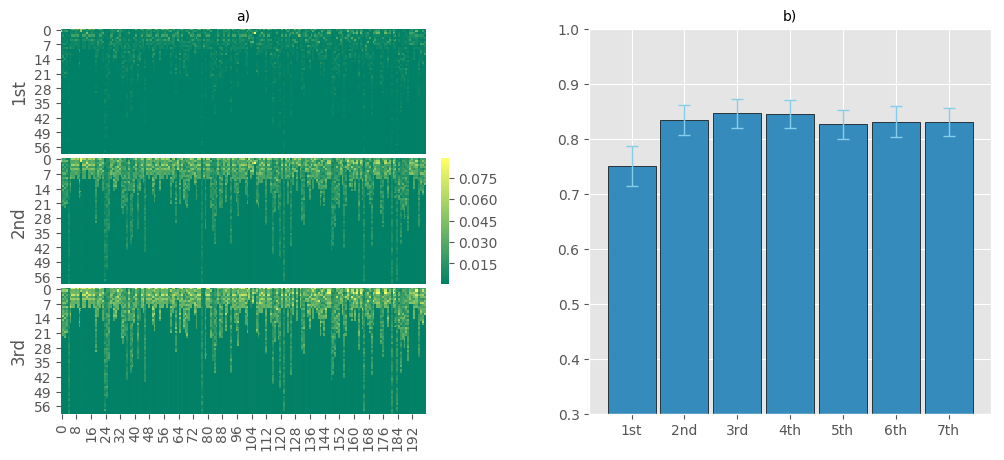

In [154]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt


import seaborn as sns; 
import matplotlib.gridspec as gridspec
plt.style.use(['ggplot'])

att_data = [layer0, layer1, layer2]

fig = plt.figure(tight_layout=True, figsize=(12,5))
gs = gridspec.GridSpec(3, 4, width_ratios=[1,0.02,0.3,1.1])
gs.update(wspace=0.07, hspace=0.03)
ax1 = fig.add_subplot(gs[:, 3])
average_precision[0] = 0.75
ax1.bar(['1st', '2nd', '3rd', '4th', '5th', '6th', '7th'], average_precision, 0.91, color='#358CBC', yerr=errors, alpha=1, edgecolor='black', error_kw=dict(lw=1, capsize=4, capthick=1, ecolor='skyblue'))
ax1.set_ylim([0.3, 1])
ax1.set_title('b)', size=10)

axes = []
for i in range(3):
    ax2 = fig.add_subplot(gs[i, 0])
    axes.append(ax2)
    if i == 0:
        ax2.set_title('a)', size=10)
    ax2.set_ylabel('d')
    if i != 2:
        ax2.set_xticklabels([])
        sns.heatmap(att_data[i], ax=ax2, cbar=False, cmap='summer')
        #ax2.imshow(att_data[i])
        #ax2.grid([])
    else:
        #s = ax2.imshow(att_data[i])
        #cax = fig.add_subplot(gs[1,1])
        #fig.colorbar(s, ax=cax)
        ccc = sns.color_palette("gray", 100)
        
        sns.heatmap(att_data[i], ax=ax2, cbar_ax=fig.add_subplot(gs[1,1]), cmap='summer')
        #ax2.grid([])

axes[0].set_xticklabels([])
axes[0].set_xticks([])
axes[1].set_xticklabels([])
axes[1].set_xticks([])
axes[0].set_ylabel('1st')
axes[1].set_ylabel('2nd')
axes[2].set_ylabel('3rd')
fig.align_labels()

plt.savefig('attention_high_multistep_all.png', dpi=500, bbox_inches = 'tight', pad_inches = 0)